# Identify Issues with Motion State Detection

In [1]:
import sys
import os
import boto3
import json
import datetime
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

from io import BytesIO

CANSERVER_PARSED_BUCKET = 'matt3r-canserver-us-west-2'
CANSERVER_EVENT_BUCKET = 'matt3r-canserver-event-us-west-2'
IMU_BUCKET = 'matt3r-imu-us-west-2'
s3_client = boto3.client('s3')

Create data collection class

In [2]:
class DataCollection:
    def __init__(self, org_id, k3y_id, start_date, end_date):
        self.org_id = org_id
        self.k3y_id = k3y_id
        self.start_date = start_date
        self.end_date = end_date

    def get_events(self):
        # get a list of all json files in the prefix and filter them to within the date range
        response = s3_client.list_objects(Bucket=CANSERVER_EVENT_BUCKET, Prefix=self.org_id + '/' + 'k3y-' + self.k3y_id + '/')
        all_keys = [item['Key'] for item in response['Contents']]
        keys = [file for file in all_keys if file.split('.')[-1] == 'json'
                and len(file.split('/')[-1]) == 15
                and datetime.datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d') >= self.start_date
                and datetime.datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d') <= self.end_date]
        keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

        # retrieve and combine filtered json files
        event_dict = {}
        for key in keys:
            response = s3_client.get_object(Bucket=CANSERVER_EVENT_BUCKET, Key=key)
            result = json.loads(response["Body"].read().decode())
            for index in result['imu_telematics']:
                if index in event_dict:
                    event_dict[index].extend(result['imu_telematics'][index])
                else:
                    event_dict[index] = result['imu_telematics'][index]

        return event_dict
    
    def get_can_data(self):
        # get a list of all parquet files in the prefix and filter them to within the date range
        response = s3_client.list_objects_v2(Bucket=CANSERVER_PARSED_BUCKET, Prefix=self.org_id + '/' + 'k3y-' + self.k3y_id + '/')
        all_keys = [item['Key'] for item in response.get('Contents', [])]

        while response['IsTruncated']:
            response = s3_client.list_objects_v2(Bucket=CANSERVER_PARSED_BUCKET, Prefix=self.org_id + '/' + 'k3y-' + self.k3y_id + '/', ContinuationToken=response['NextContinuationToken'])
            all_keys.extend([item['Key'] for item in response.get('Contents', [])])

        keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
                and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') >= self.start_date
                and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') <= self.end_date]
        keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

        # retrieve and combine filtered perquet files
        df_list = []
        for key in keys:
            response = s3_client.get_object(Bucket=CANSERVER_PARSED_BUCKET, Key=key)
            buffer = BytesIO(response['Body'].read())
            can_df = pd.read_parquet(buffer, engine='pyarrow')
            df_list.append(can_df)
        try:
            can_df = pd.concat(df_list, axis=0, ignore_index=True)
        except:
            print("ERROR: No CAN Server data available")
            sys.exit(1)

        return can_df
        
    def fetch_imu_data(self):
        # get a list of all parquet files in the prefix and filter them to within the date range
        response = s3_client.list_objects_v2(Bucket=IMU_BUCKET, Prefix=self.org_id + '/' + 'k3y-' + self.k3y_id + '/accel/')
        all_keys = [item['Key'] for item in response.get('Contents', [])]

        while response['IsTruncated']:
            response = s3_client.list_objects_v2(Bucket=IMU_BUCKET, Prefix=self.org_id + '/' + 'k3y-' + self.k3y_id + '/accel/', ContinuationToken=response['NextContinuationToken'])
            all_keys.extend([item['Key'] for item in response.get('Contents', [])])
        
        keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
                and len(file.split('/')[-1].split('_')[0]) == 10
                and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') >= self.start_date
                and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') <= self.end_date]
        keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

        # retrieve and combine filtered perquet files
        df_list = []
        for key in keys:
            response = s3_client.get_object(Bucket=IMU_BUCKET, Key=key)
            buffer = BytesIO(response['Body'].read())
            imu_df = pd.read_parquet(buffer, engine='pyarrow')
            df_list.append(imu_df)
        try:
            imu_df = pd.concat(df_list, axis=0, ignore_index=True)
        except ValueError:
            print("ERROR: No IMU acceleration data available")
            sys.exit(1)

        return imu_df
    
    def fetch_time_data(self):
        # create a 1 day buffer to capture any data on the boundaries
        start_date = self.start_date - datetime.timedelta(days=1)
        # end_date = self.end_date + datetime.timedelta(days=1)
        end_date = self.end_date
        # get a list of all parquet files in the prefix and filter them to within the date range
        response = s3_client.list_objects(Bucket=IMU_BUCKET, Prefix=self.org_id + '/' + 'k3y-' + self.k3y_id + '/infer/')
        all_keys = [item['Key'] for item in response['Contents']]
        keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
                and len(file.split('/')[-1].split('.')[0]) != 10
                and datetime.datetime.strptime(file.split('/')[-1].split('.')[0].split('_')[-1], '%Y-%m-%d') >= start_date
                and datetime.datetime.strptime(file.split('/')[-1].split('.')[0].split('_')[-1], '%Y-%m-%d') <= end_date]
        keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

        # retrieve and combine filtered perquet files
        df_list = []
        for key in keys:
            response = s3_client.get_object(Bucket=IMU_BUCKET, Key=key)
            buffer = BytesIO(response['Body'].read())
            time_df = pd.read_parquet(buffer, engine='pyarrow')
            df_list.append(time_df)
        try:
            time_df = pd.concat(df_list, axis=0, ignore_index=True)
        except ValueError:
            print("ERROR: No IMU infer data available")
            sys.exit(1)

        # drop any nan values
        time_df.dropna(subset=['diff_sw_sys(second)', 'imu_sw_clock(epoch)', 'system_clock(epoch)'], inplace=True)
        time_df.reset_index(drop=True, inplace=True)

        return time_df

Define main functions

In [73]:
# define constants
STATIONARY_SPEED = 0.5
SPEED_NOISE_WINDOW = 0.5
BUFFER_TIME = 30
PLOT_WINDOW = 120
NUM_PLOTS = 3

# validation thresholds
TPR_THRESHOLD = 99.8
FPR_THRESHOLD = 0.5

def shift_time(imu_df, time_df):
    # identify any jumps in the data
    JUMP_LIMIT = 2
    jump_indexes = time_df[abs(time_df['diff_sw_sys(second)'].diff()) > JUMP_LIMIT].index
    jump_indexes = jump_indexes.append(pd.Index([time_df.index[-1]]))

    # create a list of the slope segments
    segments = []
    index_start = 0
    for index in jump_indexes:
        seg_data = {}
        seg_data['start_timestamp'] = time_df['imu_sw_clock(epoch)'].iloc[index_start]
        seg_data['end_timestamp'] = time_df['imu_sw_clock(epoch)'].iloc[index]
        seg_data['slope'], seg_data['intercept'] = np.polyfit(time_df['system_clock(epoch)'][index_start:index], 
                                                            time_df['diff_sw_sys(second)'][index_start:index], 1)
        seg_data['offset'] = seg_data['slope'] * seg_data['start_timestamp'] + seg_data['intercept']
        segments.append(seg_data)
        index_start = index

    for seg in segments:
        imu_df_seg = imu_df[(imu_df['timestamp(epoch in sec)'] >= seg['start_timestamp'])
                            & (imu_df['timestamp(epoch in sec)'] < seg['end_timestamp'])]
        imu_df.loc[imu_df_seg.index, 'correct_timestamp'] = imu_df_seg['timestamp(epoch in sec)'].apply(
            lambda x: x - (x - seg['start_timestamp']) * seg['slope'] - seg['offset'])

    # drop any nan values
    imu_df.dropna(inplace=True)
    imu_df.reset_index(drop=True, inplace=True)

    return imu_df

# Filter the driving state data based on CAN Server speed
def get_can_driving_data(can_df, imu_df):
    speed_df = can_df[can_df['speed'].notna()].copy()
    speed_df.reset_index(drop=True, inplace=True)
    speed_df['driving'] = abs(speed_df['speed']) > STATIONARY_SPEED
    dr_start_times = speed_df[speed_df['driving'].astype(int).diff() == 1]['timestamp'].to_list()
    dr_end_times = speed_df[speed_df['driving'].astype(int).diff() == -1]['timestamp'].to_list()

    dr_df_states = []
    for i in range(min(len(dr_start_times),len(dr_end_times))):
        # filter out noise
        if dr_end_times[i] - dr_start_times[i] > SPEED_NOISE_WINDOW:
            dr_df_states.append(imu_df[(imu_df['correct_timestamp'] >= dr_start_times[i]) 
                            & (imu_df['correct_timestamp'] <= dr_end_times[i])])
    try:
        can_dr_df = pd.concat(dr_df_states, ignore_index=True)
    except ValueError:
        print('ERROR: No CAN Server driving state data available')
        sys.exit(1)
    return can_dr_df

# Filter the driving state data based on the IMU motion states
def get_imu_driving_data(imu_df, time_df):
    time_df['motion_bin'] = time_df['motion_state'].apply(lambda x: x != 'stationary').astype(int)
    dr_start_times = time_df[time_df['motion_bin'].diff() == 1]['system_clock(epoch)'].to_list()
    dr_end_times = time_df[time_df['motion_bin'].diff() == -1]['system_clock(epoch)'].to_list()

    imu_df['driving_state'] = imu_df['correct_timestamp'].apply(
        lambda x: any(dr_start - BUFFER_TIME <= x <= dr_end for dr_start, dr_end in zip(dr_start_times, dr_end_times))
    )

    imu_dr_df = imu_df[imu_df['driving_state']]
    return imu_dr_df

# compute the true positive rate based on the driving state data
def TPR(can_dr_df, imu_dr_df, event_dict):
    dr_start_times = [state['start'] for state in event_dict['driving_state']]
    dr_end_times = [state['end'] for state in event_dict['driving_state']]

    # proxy_set = set(imu_dr_df[imu_dr_df['correct_timestamp'].apply(lambda x: any(start <= x <= end for start, end in zip(dr_start_times, dr_end_times)))]['correct_timestamp'].to_list())
    # truth_set = set(can_dr_df[can_dr_df['correct_timestamp'].apply(lambda x: any(start <= x <= end for start, end in zip(dr_start_times, dr_end_times)))]['correct_timestamp'].to_list())

    proxy_set = set(imu_dr_df['correct_timestamp'].to_list())
    truth_set = set(can_dr_df['correct_timestamp'].to_list())

    return len(truth_set.intersection(proxy_set)) / len(truth_set)

# compute the false positive rate based on the parked state data
def FPR(imu_df, imu_dr_df, event_dict):
    pk_start_times = [state['timestamp'][0] for state in event_dict['parked_state']]
    pk_end_times = [state['timestamp'][1] for state in event_dict['parked_state']]

    proxy_set = set(imu_dr_df[imu_dr_df['correct_timestamp'].apply(lambda x: any(start <= x <= end for start, end in zip(pk_start_times, pk_end_times)))]['correct_timestamp'].to_list())
    truth_set = set(imu_df[imu_df['correct_timestamp'].apply(lambda x: any(start <= x <= end for start, end in zip(pk_start_times, pk_end_times)))]['correct_timestamp'].to_list())

    try:
        fpr = len(proxy_set) / len(truth_set)
    except ZeroDivisionError:
        print('ERROR: No parked state data available')
        sys.exit(1)
    return fpr

Run main method

In [76]:
# ============================
# imput k3y data
organization_id = 'hamid'
k3y_id = '17700cf8'
# ============================

event = {
  "time": "2023-08-01T00:00:00Z"
}

print("event", event)
current_time = event['time']

prev_day = datetime.datetime.strptime(current_time, '%Y-%m-%dT%H:%M:%SZ') - datetime.timedelta(days=1)
start_date = datetime.datetime.combine(prev_day, datetime.time.min)
end_date = datetime.datetime.combine(prev_day, datetime.time.max)

# fetch the data from the S3 buckets
data_collector = DataCollection(organization_id, k3y_id, start_date, end_date)
imu_df = data_collector.fetch_imu_data()
time_df = data_collector.fetch_time_data()
event_dict = data_collector.get_events()
can_df = data_collector.get_can_data()

# correct the imu time
imu_df = shift_time(imu_df, time_df)
imu_df['norm_acc'] = np.sqrt(imu_df['lr_acc(m/s^2)']**2 + imu_df['bf_acc(m/s^2)']**2 + imu_df['vert_acc(m/s^2)']**2)

# filter only driving state data
can_dr_df = get_can_driving_data(can_df, imu_df)
imu_dr_df = get_imu_driving_data(imu_df, time_df)

# compute the validation metrics
tpr = TPR(can_dr_df, imu_dr_df, event_dict) * 100
fpr = FPR(imu_df, imu_dr_df, event_dict) * 100

# print results
print(f'motion state metrics for {prev_day.strftime("%Y-%m-%d")}:')
print(f'TPR is {tpr:.3f}%')
print(f'FPR is {fpr:.3f}%')

if tpr < TPR_THRESHOLD:
    print(f'ERROR: TPR is below {TPR_THRESHOLD}%')
    sys.exit(1)
elif fpr > FPR_THRESHOLD:
    print(f'ERROR: FPR is above {FPR_THRESHOLD}%')
    sys.exit(1)
else:
    print('motion state detection meets criteria')

event {'time': '2023-08-01T00:00:00Z'}
motion state metrics for 2023-07-31:
TPR is 100.000%
FPR is 0.019%
motion state detection meets criteria


Get only the data that is not detected in the TPR

In [65]:
dr_start_times = [state['start'] for state in event_dict['driving_state']]
dr_end_times = [state['end'] for state in event_dict['driving_state']]

proxy_set = set(imu_dr_df[imu_dr_df['correct_timestamp'].apply(lambda x: any(start <= x <= end for start, end in zip(dr_start_times, dr_end_times)))]['correct_timestamp'].to_list())
truth_set = set(can_dr_df['correct_timestamp'].to_list())
captured_set = truth_set.intersection(proxy_set)
result_set = truth_set.difference(captured_set)

result_df = imu_dr_df[imu_dr_df['correct_timestamp'].isin(result_set)]

In [8]:
len(captured_set)

31417

In [9]:
len(truth_set)

32076

In [10]:
len(result_set)

659

In [11]:
result_df

,timestamp(epoch in sec),lr_acc(m/s^2),bf_acc(m/s^2),vert_acc(m/s^2),correct_timestamp,norm_acc,driving_state
164216,1.690591e+09,0.007310,-0.387277,0.098398,1.690591e+09,0.399649,True
164217,1.690591e+09,0.027757,-0.378298,0.140873,1.690591e+09,0.404629,True
164218,1.690591e+09,0.041027,-0.330430,0.034402,1.690591e+09,0.334739,True
164219,1.690591e+09,0.046982,-0.294333,-0.007426,1.690591e+09,0.298151,True
164220,1.690591e+09,0.058806,-0.251257,-0.021766,1.690591e+09,0.258963,True
...,...,...,...,...,...,...,...
193992,1.690592e+09,0.073860,-0.173871,-0.133226,1.690592e+09,0.231161,True
193993,1.690592e+09,0.064728,-0.176060,-0.128229,1.690592e+09,0.227221,True
193994,1.690592e+09,0.002135,-0.209533,0.038781,1.690592e+09,0.213103,True
193995,1.690592e+09,-0.134821,-0.216137,0.132744,1.690592e+09,0.287251,True


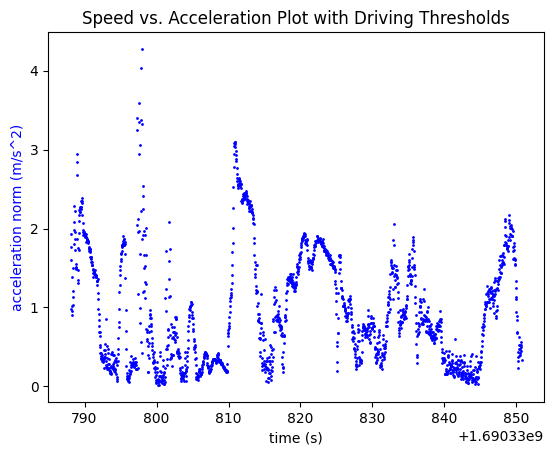

In [66]:
import matplotlib.pyplot as plt
df_dr = result_df
# df_ss = imu_ss_df
y_data = 'norm_acc'

window = 120
buffer = 1000

fig, ax1 = plt.subplots()

# can_dr = can_motion[can_motion['speed'] > 0.5]
# can_ss = can_motion[can_motion['speed'] <= 0.5]

ax1.scatter(x=df_dr['correct_timestamp'], y=df_dr[y_data], s=1, color='blue')
# ax1.scatter(x=df_ss['correct_timestamp'], y=df_ss[y_data], s=1, color='purple')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('acceleration norm (m/s^2)', color='blue')

# ax2 = ax1.twinx()
# ax2.scatter(can_dr['timestamp'], abs(can_dr['speed']), color='red', s=1)
# ax2.scatter(can_ss['timestamp'], abs(can_ss['speed']), color='orange', s=1)
# ax2.set_ylabel('speed (km/h)', color='red')

left = -20600
right = -20400
# ax1.set_xlim(left, right)
# ax2.set_xlim(left, right)

plt.title('Speed vs. Acceleration Plot with Driving Thresholds')

plt.show()

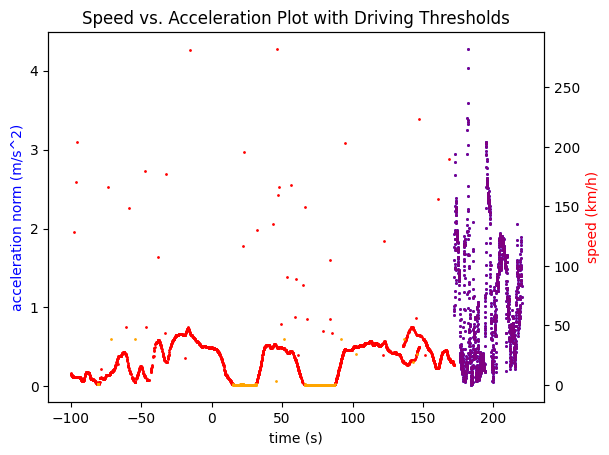

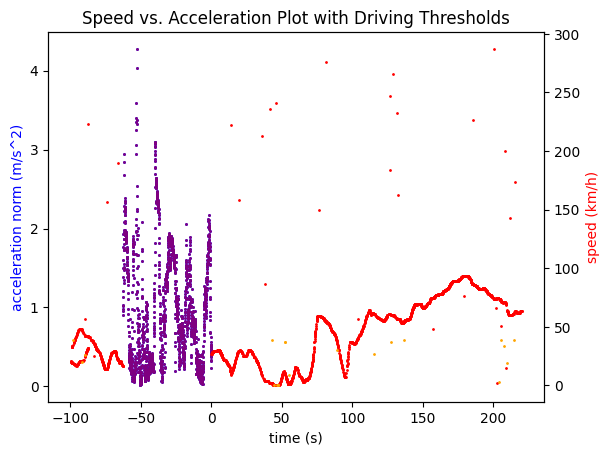

In [67]:
df_dr = result_df
df_ss = result_df
y_data = 'norm_acc'

window = 120
buffer = 100
count = 0

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        acc_dr = df_dr[(df_dr['correct_timestamp'] >= dr_start_time - buffer) 
                          & (df_dr['correct_timestamp'] <= dr_start_time + window + buffer)]
        acc_ss = df_ss[(df_ss['correct_timestamp'] >= dr_start_time - buffer) 
                          & (df_ss['correct_timestamp'] <= dr_start_time + window + buffer)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time - buffer) 
                            & (can_df['timestamp'] <= dr_start_time + window + buffer)]
        dr_start_time += window

        count += 1
        if ((len(acc_dr) + len(acc_ss) != 0) and (len(can_motion) != 0)):
            fig, ax1 = plt.subplots()

            can_dr = can_motion[can_motion['speed'] > 0.5]
            can_ss = can_motion[can_motion['speed'] <= 0.5]

            ax1.scatter(x=acc_dr['correct_timestamp'] - dr_start_time + window, y=acc_dr[y_data], s=1, color='blue')
            ax1.scatter(x=acc_ss['correct_timestamp'] - dr_start_time + window, y=acc_ss[y_data], s=1, color='purple')
            ax1.set_xlabel('time (s)')
            ax1.set_ylabel('acceleration norm (m/s^2)', color='blue')

            ax2 = ax1.twinx()
            ax2.scatter(can_dr['timestamp'] - dr_start_time + window, abs(can_dr['speed']), color='red', s=1)
            ax2.scatter(can_ss['timestamp'] - dr_start_time + window, abs(can_ss['speed']), color='orange', s=1)
            ax2.set_ylabel('speed (km/h)', color='red')
            
            plt.title('Speed vs. Acceleration Plot with Driving Thresholds')

            plt.show()

In [ ]:
df_dr = result_df
df_ss = result_df
y_data = 'lr_acc(m/s^2)'

window = 120
buffer = 20
count = 0

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        acc_dr = df_dr[(df_dr['correct_timestamp'] >= dr_start_time - buffer) 
                          & (df_dr['correct_timestamp'] <= dr_start_time + window + buffer)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time - buffer) 
                            & (can_df['timestamp'] <= dr_start_time + window + buffer)]
        dr_start_time += window

        count += 1
        if ((len(acc_dr) != 0) and (len(can_motion) != 0)):
            fig, ax1 = plt.subplots()

            ax1.scatter(x=acc_dr['correct_timestamp'] - dr_start_time + window, y=acc_dr[y_data], s=1, color='blue')
            ax1.set_xlabel('time (s)')
            ax1.set_ylabel('acceleration norm (m/s^2)', color='blue')

            ax1.scatter(can_motion['timestamp'] - dr_start_time + window, abs(can_motion['lr_acc']), color='red', s=1)
            
            plt.title('Speed vs. Acceleration Plot with Driving Thresholds')

            plt.show()

Plot the Time Drift

In [25]:
time_df

,imu_sw_clock(epoch),system_clock(epoch),diff_sw_sys(second),counter,temp(C),motion_state,motion_bin
0,1.690502e+09,1.690502e+09,-22.778185,1082898365,72.01,stationary,0
1,1.690502e+09,1.690502e+09,-22.589055,1083985853,72.36,stationary,0
2,1.690502e+09,1.690502e+09,-21.875361,1085073341,72.11,stationary,0
3,1.690502e+09,1.690502e+09,-21.507814,1086160829,72.55,stationary,0
4,1.690502e+09,1.690503e+09,-22.990523,1087248317,72.57,stationary,0
...,...,...,...,...,...,...,...
7212,1.690675e+09,1.690675e+09,-22.107522,1028064701,71.76,stationary,0
7213,1.690675e+09,1.690675e+09,-23.474550,1029152189,71.60,stationary,0
7214,1.690675e+09,1.690675e+09,-22.877177,1030242749,71.61,stationary,0
7215,1.690675e+09,1.690675e+09,-22.246566,1031333309,71.57,stationary,0


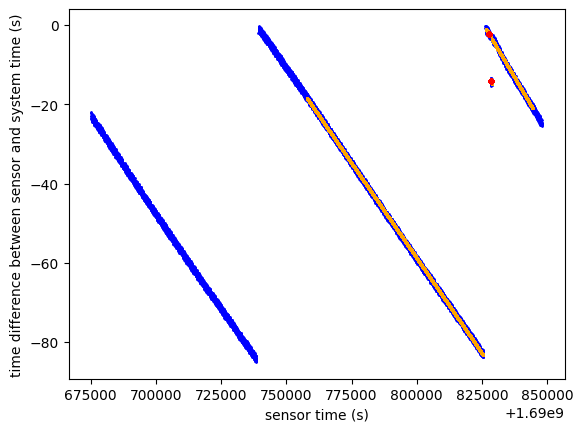

In [63]:
# plot actual time drift vs. predicted time drift
fig, ax = plt.subplots()

ax.scatter(x=time_df['imu_sw_clock(epoch)'], y=time_df['diff_sw_sys(second)'], s=1, color='blue')
ax.scatter(x=imu_df['timestamp(epoch in sec)'], y=imu_df['timestamp(epoch in sec)'] - imu_df['correct_timestamp'], s=1, color='orange')
ax.scatter(x=result_df['timestamp(epoch in sec)'], y=result_df['timestamp(epoch in sec)'] - result_df['correct_timestamp'], s=10, color='red')
left = 589000
right = 594000
# ax.set_xlim(left + 1.69*10**9, right + 1.69*10**9)
plt.xlabel('sensor time (s)')
plt.ylabel('time difference between sensor and system time (s)')

plt.show()